<a href="https://colab.research.google.com/github/kavyajeetbora/time_series_deeplearning.ai/blob/main/week2/modelling_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Creating synthetic time series

In [4]:
def plot_series(time,series,format="-",start=0,end=None, label=None):
    plt.plot(time[start:end],series[start:end],format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4, np.cos(season_time*2*np.pi), 1/np.exp(season_time*3))

def seasonality(time, period, amplitude, phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=42):
    rnd = np.random.RandomState(seed)
    return noise_level * rnd.randn(len(time))

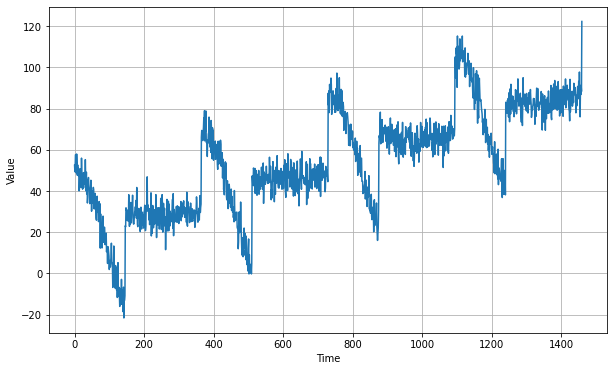

In [10]:
time = np.arange(365*4+1,dtype="float32")
baseline = 10
amplitude = 40
slope=0.05
noise_level = 5

## create a time series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
## update with noise
series += noise(time, noise_level=noise_level,seed=42) 

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

## preparing the features and labels for training

In [12]:
## splitting the dataset into train and test datasets:
split_time = 1000
train_time = time[0:split_time]
valid_time = time[split_time:]
x_train = series[0:split_time]
x_valid = series[split_time:]


window_size = 20
batch_size = 32
shuffle_buffer_size=1000

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(batch_size))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda x: (x[:-1], x[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Modeling the time series

In [16]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
layer1 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([layer1])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)
print("Layer weights {}".format(model.get_weights()))

Layer weights [array([[-0.07276785],
       [-0.01581138],
       [ 0.10473516],
       [-0.00716396],
       [ 0.00271364],
       [-0.01628578],
       [ 0.00403171],
       [ 0.0011253 ],
       [-0.02914432],
       [ 0.02526068],
       [-0.02532163],
       [ 0.06943806],
       [-0.06182555],
       [-0.01077973],
       [ 0.04379748],
       [ 0.07736272],
       [ 0.01087463],
       [ 0.20715961],
       [ 0.21175933],
       [ 0.47227234]], dtype=float32), array([0.01254097], dtype=float32)]


These are the layer weights and one bias weight

## Prediction of time series:

In [18]:
model.predict(series[:window_size][np.newaxis])

array([[44.192333]], dtype=float32)

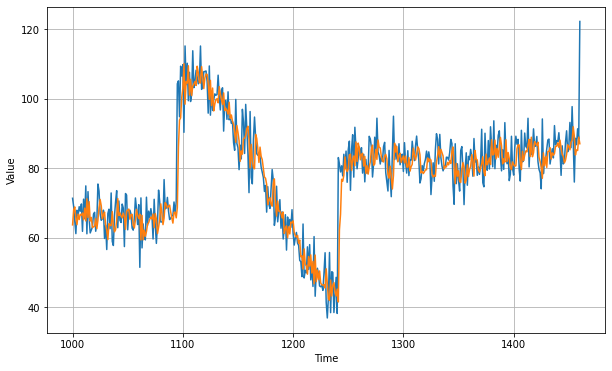

CPU times: user 56.5 s, sys: 935 ms, total: 57.4 s
Wall time: 57 s


In [28]:
%%time
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))


## extracting only the validation part from the predictions
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(valid_time, x_valid, label="time series validation set")
plot_series(valid_time, results, label="predictions")
plt.show()

## evaluation of the model

In [29]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9843884

## Deep neural network training, tuning and prediction

In [33]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])

model2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model2.fit(dataset, epochs=100, verbose=0)
print("Layer weights {}".format(model2.get_weights()))

Layer weights [array([[-0.39976865,  0.27845523,  0.1681214 ,  0.22635284, -0.28211287,
        -0.1633654 , -0.03568917, -0.3313986 , -0.06509154, -0.33039084],
       [-0.01055358, -0.17525828, -0.14596665, -0.10555547,  0.22354934,
         0.25547686,  0.01501331, -0.01089378, -0.0846031 , -0.01325893],
       [ 0.25542992, -0.03109026,  0.38460514, -0.18098915, -0.40334824,
         0.23629403,  0.34143862,  0.16061649, -0.20357034, -0.2359116 ],
       [ 0.36398444,  0.18219836, -0.3801349 ,  0.28717473, -0.38980275,
         0.1444304 , -0.0367636 ,  0.05793456, -0.27891326,  0.32305261],
       [-0.36789796, -0.35321906, -0.27050695, -0.05778558, -0.03875469,
        -0.02653497, -0.25593218, -0.3788045 , -0.01046398, -0.27981693],
       [-0.19004841,  0.26480085,  0.3536309 , -0.32381007,  0.33772025,
         0.04202807, -0.16869135,  0.34041142, -0.28572407, -0.04459953],
       [-0.07538206,  0.05860677, -0.3501265 , -0.01915723, -0.39751977,
        -0.3527417 ,  0.414258

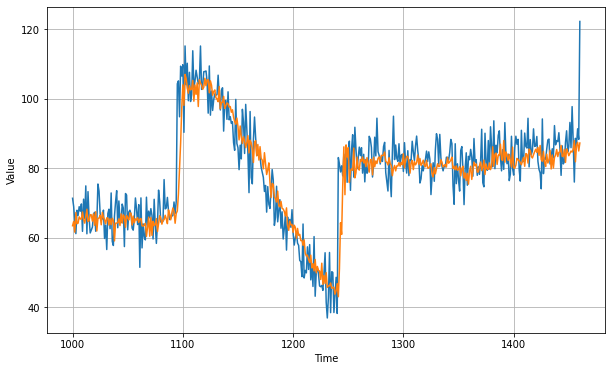

CPU times: user 56.4 s, sys: 858 ms, total: 57.2 s
Wall time: 56.7 s


In [34]:
%%time
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model2.predict(series[time:time+window_size][np.newaxis]))


## extracting only the validation part from the predictions
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(valid_time, x_valid, label="time series validation set")
plot_series(valid_time, results, label="predictions")
plt.show()

In [35]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.04685

### tuning the learning rate with learning rate scheduler

it will change the learning rates to a value based on the epoch number

In [49]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

model2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history = model2.fit(dataset, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 1308.9354
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 1186.1234
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 984.6647
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 823.5195
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 685.7713
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 564.3383
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 483.1076
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 374.6611
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 280.9353
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 212.6611
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 165.0931
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 119.1776
Epoch 13/10

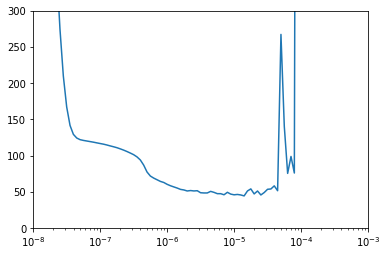

In [50]:
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3,0,300])
plt.show()

In [51]:
best_lr = lrs[np.argmin(history.history["loss"])]
best_lr

0.00014125375446227554

In [52]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])
model2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9))
history = model2.fit(dataset, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 3798.3027
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 2573.6048
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 1390.6648
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 894.5877
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 493.0499
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 274.0065
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 170.3417
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 97.9396
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 64.0154
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 70.1902
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 70.4127
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 63.3407
Epoch 13/100
31